# Credits:
1. [IEEE - FE with some EDA](https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda), by [Konstantin Yakovlev](https://www.kaggle.com/kyakovlev)
2. [Adversarial IEEE](https://www.kaggle.com/tunguz/adversarial-ieee), by [Bojan Tunguz](https://www.kaggle.com/tunguz)

# Objective:
I would like to see how stable the current public kernels are. That's why I pulled the features by [Konstantin Yakovlev](https://www.kaggle.com/kyakovlev) and put them to [Bojan Tunguz](https://www.kaggle.com/tunguz)'s Adversarial Validation script. 

# Validationが0.5くらいにいることを確認する

In [44]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import model_selection, preprocessing, metrics
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import shap
import os
from sklearn import preprocessing
import xgboost as xgb
import gc


import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)

## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def make_groupby_from(df, groupby_col, agg_func):
    groupby_df = df.groupby(groupby_col).agg({"賃料":agg_func}).reset_index().fillna(0)
    agg_func_column = [f"{agg}_{'&'.join(groupby_col)}" for agg in agg_func]
    groupby_df.columns = groupby_col + agg_func_column
    return groupby_df

In [59]:
train = pd.read_csv("data/train_processed_add_groupby.csv")
test = pd.read_csv("data/test_processed_add_groupby.csv")
train = pd.read_csv("data/train_processed_add_groupby_geocoding.csv")
test = pd.read_csv("data/test_processed_add_groupby_geocoding.csv")
train = pd.read_csv("data/train_processed_add_geocoding_meshcode.csv")
test = pd.read_csv("data/test_processed_add_geocoding_meshcode.csv")
train = pd.read_csv("data/train_processed_add_geocoding_meshcode_crime.csv")
test = pd.read_csv("data/test_processed_add_geocoding_meshcode_crime.csv")
train = pd.read_csv("data/train_processed_add_geocoding_meshcode_crime_landprice.csv")
test = pd.read_csv("data/test_processed_add_geocoding_meshcode_crime_landprice.csv")
train = pd.read_csv("data/train_processed_add_geocoding_meshcode_crime_landprice_log_groupby.csv")
test = pd.read_csv("data/test_processed_add_geocoding_meshcode_crime_landprice_log_groupby.csv")
train = pd.read_csv("data/train_processed_add_geocoding_meshcode_crime_landprice_log_groupby.csv")
test = pd.read_csv("data/test_processed_add_geocoding_meshcode_crime_landprice_log_groupby.csv")


remove_features = ["所在地", "アクセス", "番地", "tokens", "id", "賃料"]
print(remove_features)
########################### Final features list
features = [col for col in test.columns if col not in remove_features]
train = train[features]
test = test[features]
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


categorical_feats_name = ['方角','建物構造','区', "railway", "丁目"]
categorical_feats_indices = []
for col in categorical_feats_name:
    categorical_feats_indices.append(list(train[features].columns).index(col))

['所在地', 'アクセス', '番地', 'tokens', 'id', '賃料']
Mem. usage decreased to 22.45 Mb (75.8% reduction)
Mem. usage decreased to 22.30 Mb (75.8% reduction)


In [60]:
train.shape

(31470, 386)

In [61]:
test.shape

(31262, 386)

In [62]:
train['target'] = 0
test['target'] = 1

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [63]:
train_test = pd.concat([train, test], axis =0)

target = train_test['target'].values

In [64]:
del train, test

In [65]:
gc.collect()

82065

In [66]:
train, test = model_selection.train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)

In [67]:
del train_test
gc.collect()

0

In [68]:
train_y = train['target'].values
test_y = test['target'].values
del train['target'], test['target']
gc.collect()

0

In [69]:
train = lgb.Dataset(train, label=train_y)
test = lgb.Dataset(test, label=test_y)

In [70]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.2,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 44,
         "metric": 'auc',
         "verbosity": -1}

In [71]:
num_round = 1000
clf = lgb.train(param, train, num_round, valid_sets = [train, test], verbose_eval=50, categorical_feature = categorical_feats_indices)

categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 10, 122, 200]
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[50]	training's auc: 0.665662	valid_1's auc: 0.504051
[100]	training's auc: 0.718932	valid_1's auc: 0.505251
[150]	training's auc: 0.760781	valid_1's auc: 0.503621
[200]	training's auc: 0.795144	valid_1's auc: 0.506101
[250]	training's auc: 0.820535	valid_1's auc: 0.505033
[300]	training's auc: 0.841379	valid_1's auc: 0.503533
[350]	training's auc: 0.859251	valid_1's auc: 0.502961
[400]	training's auc: 0.875202	valid_1's auc: 0.50175
[450]	training's auc: 0.887333	valid_1's auc: 0.502081
[500]	training's auc: 0.897577	valid_1's auc: 0.502374
[550]	training's auc: 0.906605	valid_1's auc: 0.502852
[600]	training's auc: 0.914966	valid_1's auc: 0.503006
[650]	training's auc: 0.923239	valid_1's auc: 0.502605
[700]	training's auc: 0.930318	valid_1's auc: 0.501461
[750]	training's auc: 0.936317	valid_1's auc: 0.501439
[800]	training's auc: 0.942107	valid_1's auc: 0.500685
[850]	training's auc: 0.946606	valid_1's auc: 0.499837
[900]	training's auc: 0.950585	valid_1's auc: 0.500331
[950]	traini

# Results:

1. The AUC for the model to predict train/test split is above 0.99
2. The following plot shows which features might be dangerous.

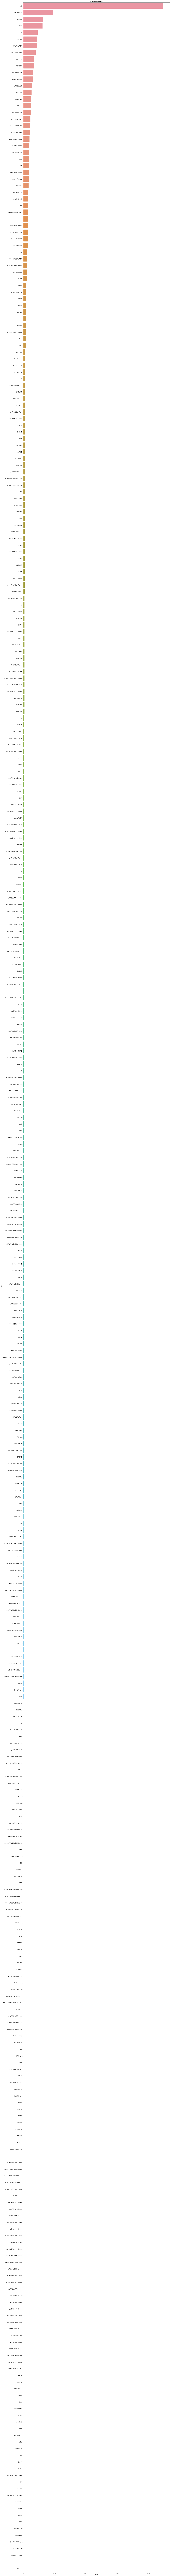

<Figure size 432x288 with 0 Axes>

In [72]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 300))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(500))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [120]:
feature_imp.sort_values(by="Value", ascending=False).head(500)

,Value,Feature
290,1670,railway
289,1114,区
288,550,【スーパー】
287,539,【コンビニ】
286,522,area-area_round
...,...,...
7,0,地下室
8,0,排水その他
9,0,汲み取り
10,0,石油暖房
